# Hot Days and Cold Nights
 
```{glue:figure} trend_fig
:scale: 50%
:align: right
```

## Setup

First, we need to import all the necessary libraries. Some of them are specifically developed to handle the download and plotting of the data and are hosted at the [indicators set-up repository](https://github.com/lauracagigal/indicators_setup) in GitHub

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import os.path as op
import sys

from myst_nb import glue 

import numpy as np
import pandas as pd
from datetime import datetime

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_int import plot_timeseries_interactive, fig_int_to_glue
from ind_setup.colors import get_df_col
from ind_setup.tables import plot_df_table, table_hot_cold_summary

sys.path.append("../../../functions")
from data_downloaders import GHCN
from temp_func import exceedance_rate_for_base_period, exceedance_rate_for_outbase_period

### Define location and variables of interest

In [2]:
country = 'Palau'
update_data = False
path_data = "../../../data"
path_figs = "../../../matrix_cc/figures"

### Observations from Koror Station

The data used for this analysis comes from the GHCN (Global Historical Climatology Network)-Daily database. <br>
This a database that addresses the critical need for historical daily temperature, precipitation, and snow records over global land areas. GHCN-Daily is a
composite of climate records from numerous sources that were merged and then subjected to a suite of
quality assurance reviews. The archive includes over 40 meteorological elements including temperature daily maximum/minimum, temperature at observation time,
precipitation and more.

https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/doc/GHCND_documentation.pdf

In [3]:
if update_data:
    df_country = GHCN.get_country_code(country)
    print(f'The GHCN code for {country} is {df_country["Code"].values[0]}')

    df_stations = GHCN.download_stations_info()
    df_country_stations = df_stations[df_stations['ID'].str.startswith(df_country.Code.values[0])]
    print(f'There are {df_country_stations.shape[0]} stations in {country}')

In [4]:
if update_data:
    GHCND_dir = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
    id = 'PSW00040309' # Koror Station
    dict_min = GHCN.extract_dict_data_var(GHCND_dir, 'TMIN', df_country_stations.loc[df_country_stations['ID'] == id])[0][0]
    dict_max = GHCN.extract_dict_data_var(GHCND_dir, 'TMAX', df_country_stations.loc[df_country_stations['ID'] == id])[0][0]
    st_data = pd.concat([dict_min['data'], (dict_max['data'])], axis=1).dropna()
    st_data['DATE'] = st_data.index
    st_data['DAY'] = "2024-" + st_data['DATE'].dt.strftime('%m-%d')
    st_data['DAY'] = pd.to_datetime(st_data['DAY'], format='%Y-%m-%d')
    st_data.index = range(len(st_data))
    st_data.to_pickle(op.join(path_data, 'GHCN_surface_temperature_hotdays.pkl'))
else:
    st_data = pd.read_pickle(op.join(path_data, 'GHCN_surface_temperature_hotdays.pkl'))

## Analysis

In [5]:
exceed_rates_TMAX = exceedance_rate_for_outbase_period(st_data, "TMAX")
exceed_rates_TMIN = exceedance_rate_for_outbase_period(st_data, "TMIN")

In [6]:
TMAX_dict = dict(zip(exceed_rates_TMAX['DAY'], exceed_rates_TMAX['THRESHOLD']))
TMIN_dict = dict(zip(exceed_rates_TMIN['DAY'], exceed_rates_TMIN['THRESHOLD']))

In [7]:
df_exceed = st_data.copy()
df_exceed['THRESHOLD_TMAX'] = df_exceed['DAY'].apply(lambda day_value:TMAX_dict.get(day_value))
df_exceed['HOT_DAY'] = df_exceed[['TMAX',"THRESHOLD_TMAX"]].apply(lambda x: x["TMAX"] > x["THRESHOLD_TMAX"],axis=1)

df_exceed['THRESHOLD_TMIN'] = df_exceed['DAY'].apply(lambda day_value:TMIN_dict.get(day_value))
df_exceed['COLD_NIGHT'] = df_exceed[['TMIN',"THRESHOLD_TMIN"]].apply(lambda x: x["TMIN"] < x["THRESHOLD_TMIN"],axis=1)

df_exceed['YEAR'] = pd.DatetimeIndex(st_data['DATE']).year

In [8]:
out_of_base_hot = {}
out_of_base_cold = {}
for x in df_exceed["YEAR"].unique():
    if x > 1990:
        out_of_base_hot[x] = df_exceed[df_exceed["YEAR"] == x]['HOT_DAY'].mean()
        out_of_base_cold[x] = df_exceed[df_exceed["YEAR"] == x]['COLD_NIGHT'].mean()

Here we are generating the count of hoy days and cold nights. A day is measured as a hot day (cold night) if it is over (below) the 90th (10th) percentile for that same day in the period 1960-1990. 

In [9]:
ex_cold, all_cold = exceedance_rate_for_base_period(st_data, "TMIN")
ex_hot, all_hot = exceedance_rate_for_base_period(st_data, "TMAX")
all_hot = ex_hot|out_of_base_hot
all_cold = ex_cold|out_of_base_cold
cold_bar = sum(ex_cold.values()) / len(ex_cold)
hot_bar = sum(ex_hot.values()) / len(ex_hot)

In [10]:
hot_anom = {}

for x in all_hot:
    hot_anom[x] = 100*(all_hot[x]-hot_bar)

cold_anom = {}
for x in all_cold:
    cold_anom[x] = 100*(all_cold[x]-cold_bar)

In [11]:
df_cold_anom = pd.DataFrame.from_dict(cold_anom, orient='index', columns=['Perc_Anom'])
df_cold_anom.index = pd.to_datetime(df_cold_anom.index, format='%Y')

df_hot_anom = pd.DataFrame.from_dict(hot_anom, orient='index', columns=['Perc_Anom'])
df_hot_anom.index = pd.to_datetime(df_hot_anom.index, format='%Y')

### Plotting

#### Cold Nights

In [12]:
dict_plot = [{'data' : df_cold_anom*3.6525, 'var' : 'Perc_Anom', 'ax' : 1, 'label' : 'Cold Nights'},]
fig, TRENDS = plot_timeseries_interactive(dict_plot, trendline=True, figsize = (25, 12), return_trend = True, label_yaxes = 'Number of days/year')

#### Hot Days

In [13]:
dict_plot = [{'data' : df_hot_anom*3.6525, 'var' : 'Perc_Anom', 'ax' : 1, 'label' : 'Hot Days'}]
fig, TRENDS = plot_timeseries_interactive(dict_plot, trendline=True, figsize = (25, 12), return_trend = True, label_yaxes = 'Number of days/year')

#### Cold Nights and Hot Days

The following plot shows how many days a year the temperature is over (below) the 90th (10th) percentile

In [14]:
dict_plot = [{'data' : df_cold_anom*3.6525, 'var' : 'Perc_Anom', 'ax' : 1, 'label' : 'Cold Nights'},
             {'data' : df_hot_anom*3.6525, 'var' : 'Perc_Anom', 'ax' : 1, 'label' : 'Hot Days'}]
fig, TRENDS = plot_timeseries_interactive(dict_plot, trendline=True, figsize = (25, 12), return_trend = True, label_yaxes = 'Number of days/year')
fig.write_html(op.join(path_figs, 'F4_ST_hot_cold.html'), include_plotlyjs="cdn")

glue("trend_cold_decade", float(TRENDS[0]*10), display=False)
glue("trend_hot_decade", float(TRENDS[1]*10), display=False)
glue("trend_fig", fig_int_to_glue(fig), display=False)


**Fig.** Number of hot days and cold nights relative to 1961–1990 climatology at Koror. Hot days are defined as days above  …10 and 90 , which corresponds to  32°C (90°F) nights. Cold nights are defined as days below 23.5°C/74°F.  The solid black lines represent trends, which are  statistically significant (p < 0.​￼​05).

The plot below shows the same information but measured as the % of time

In [15]:
dict_plot = [{'data' : df_cold_anom, 'var' : 'Perc_Anom', 'ax' : 1, 'label' : 'Cold Nights'},
             {'data' : df_hot_anom, 'var' : 'Perc_Anom', 'ax' : 1, 'label' : 'Hot Days'}]
fig, TRENDS = plot_timeseries_interactive(dict_plot, trendline=True, figsize = (25, 12), return_trend = True, label_yaxes = '% of days/year')


In [16]:
annual_cold = df_cold_anom*3.6525
annual_hot = df_hot_anom*3.6525
annual_cold['Perc_Anom'] = np.where(annual_cold['Perc_Anom'] > 0, annual_cold['Perc_Anom'], annual_cold['Perc_Anom'])
annual_hot['Perc_Anom'] = np.where(annual_hot['Perc_Anom'] > 0, annual_hot['Perc_Anom'], 0)

### Table
Here we are creating a new column with the information of the temperature refered to the climatology of 1960 to 1990

The final step is to generate a table summarizing different metrics of the data analyzed in the plots above

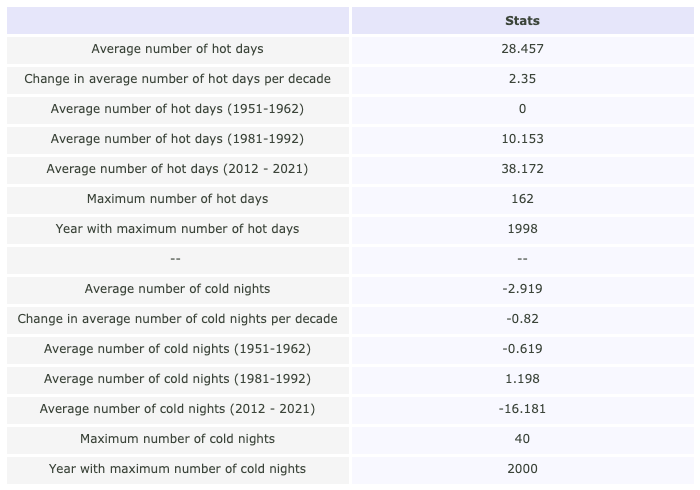

In [17]:
df = table_hot_cold_summary(annual_hot, annual_cold, TRENDS)
fig = plot_df_table(df.T, figsize = (700, 490),)